---

# 数据收集

用百度, google或者你喜欢的任何搜索引擎找到漫威英雄的图片并下载, 如果你用Chrome浏览器, 推荐一个好用的工具叫[Fatkun Batch Download Image](https://chrome.google.com/webstore/detail/fatkun-batch-download-ima/nnjjahlikiabnchcpehcpkdeckfgnohf?hl=en), 它能快速下载网页中的所有图片.

下载完成后, 我们将不同英雄的图片放置到不同的文件夹下面, 比如我这里有7个超级英雄的文件夹, 再将这些图片分成两部分, 一部分拿来训练, 另一部分用来测试. 最终就在marvel目录下有了train和valid两个目录, 它们各自又有7个文件夹对应超级英雄. 



# 正式开始

## 读取图像数据

在做图像处理之前, 我们需要将图片读取到内存中来, 并且以上文提到的**三维张量**方式表示, 以方便我们进行接下来的操作. 

我们经常会遇到有大量的图片需要训练, 将所有图片全部一次性读取进内存不现实, 所以通常会使用生成器(generator)的方式分批次读取. Keras为我们提供了方便的api来实现这一点:

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
from keras import Input, Model, optimizers
from keras.layers import Dense, regularizers, Dropout, GlobalAveragePooling2D
from keras.applications import InceptionV3, inception_v3
from sklearn.metrics import classification_report

%matplotlib inline

Using TensorFlow backend.


In [2]:
def normalize_image(images):
    return images / 127.5 - 1


def restore_image(images):
    return (images + 1) / 2


def get_image_loader(image_size, batch_size, color_mode='rgb', shuffle=True):
    image_root = "/Users/ethan/datasets/marvel"
    data_gen = ImageDataGenerator(
#         rescale=1 / 255.0,
        preprocessing_function=normalize_image
    )
    train_loader = data_gen.flow_from_directory(
        os.path.join(image_root, 'train'),
        color_mode=color_mode,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=shuffle
    )
    valid_loader = data_gen.flow_from_directory(
        os.path.join(image_root, 'valid'),
        color_mode=color_mode,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        shuffle=shuffle
    )
    return train_loader, valid_loader


train, valid = get_image_loader(image_size=224, batch_size=64, shuffle=True)

Found 2573 images belonging to 8 classes.
Found 453 images belonging to 8 classes.


这里什么意思呢, 就是我们获取到了两个读取图片的生成器, 分别对应我们的训练集和测试集, 而我们会以循环迭代的方式去获取那些图片. 每次不是获取一张, 而是一些图片, 我们叫做一个batch, 在上面的代码中我们定义了batch_size为16, 所以每一批次我们会拿到16张图片. 而每张图片我们都进行了resize, 使得每张图都是正方形, 这会方便卷积神经网络的学习. 在上面的代码中我们定义了正方形的边长为224px, 所以在每次迭代中, 我们拿到的这批图形就是16个224x224x3的三维张量堆叠在一起, 也就是一个16x224x224x3的四维张量, 理解成四维数组也行.

In [3]:
print("train中共有{}个batch, valid中共有{}个batch".format(len(train), len(valid)))

train中共有41个batch, valid中共有8个batch


将读取到的图片显示一部分出来:

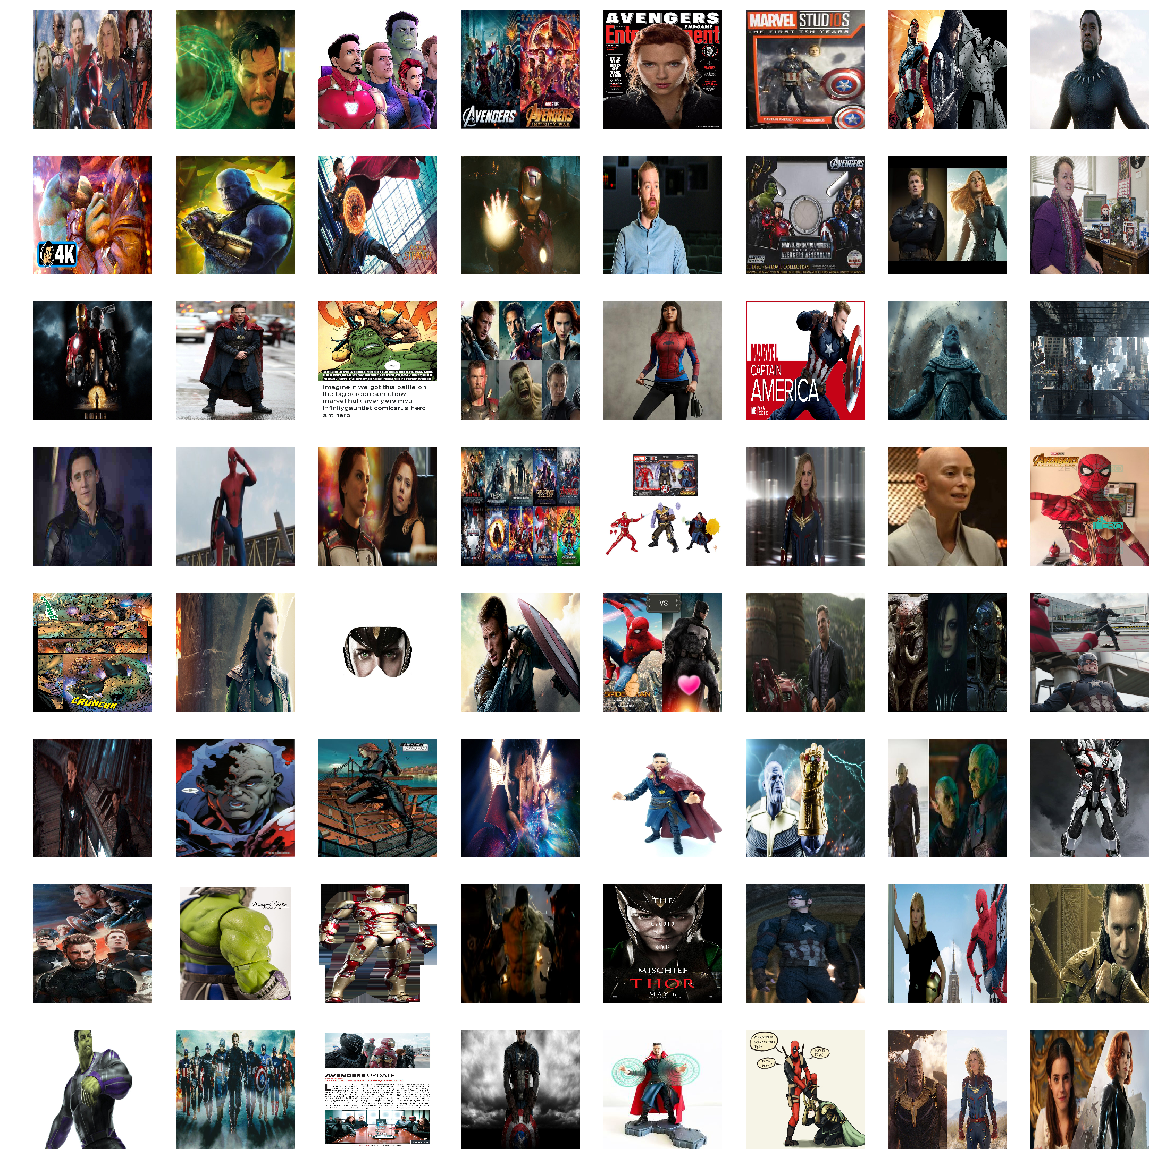

In [4]:
def display_image(*images, col=None, width=20):
    from matplotlib import pyplot as plt

    if col is None:
        col = len(images)
    row = np.math.ceil(len(images) / col)
    plt.figure(figsize=(width, (width + 1) * row / col))
    for i, image in enumerate(images):
        plt.subplot(row, col, i + 1)
        plt.axis('off')
        plt.imshow(image, cmap='gray')
    plt.show()


batch_x, _ = train[0]
restored = restore_image(batch_x)
display_image(*restored, col=8)

## 图像特征向量提取


接下来我们就要利用前人已经训练过的卷积神经网络模型来提取我们的图像集中的特征了. 至于什么是卷积, 我们一会儿在程序开始运行的时候介绍.

在这里我们使用Google发表的[Inception v3](https://arxiv.org/abs/1512.00567)模型作为基础来构建我们的神经网络:

In [5]:
def get_feature_extractor():
    base = InceptionV3(include_top=False, input_shape=(224, 224, 3), pooling='avg')
    btnk = base.get_layer('mixed8').output
    features = GlobalAveragePooling2D()(btnk)
    return Model(base.input, features)

feature_extractor = get_feature_extractor()
features = feature_extractor.predict(batch_x)
print(features.shape)

(64, 1280)


通过输出上面输出的结果我们可以看到, inception模型实际上做的是将16张224x224x3的图片简化成了16个长度为2048的向量, 向量中的每一维代表它总结出来的一个图像视觉特征. 

现在我们将数据集中的所有图像都用inception处理一遍, 得到它们的特征向量.

In [6]:
def extract_features(extractor, dataset):
    x, y = None, None
    n = len(dataset)
    for i in range(n):
        print("\r[info] 正在提取特征: batch #{}/{}...".format(i + 1, n), end='')
        batch_x, batch_y = dataset[i]
        features = extractor.predict(batch_x)
        if x is None:
            x = features
            y = batch_y
        else:
            x = np.vstack([x, features])
            y = np.vstack([y, batch_y])
    return x, y

print("\n[info] 训练集特征提取:")
x_train, y_train = extract_features(feature_extractor, train)
print("\n[info] 训练集完成!\n")

print("\n[info] 测试集特征提取:")
x_valid, y_valid = extract_features(feature_extractor, valid)
print("\n[info] 测试集完成!\n")



[info] 训练集特征提取:
[info] 正在提取特征: batch #4/41...

/Users/ethan/miniconda3/envs/ai/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


[info] 正在提取特征: batch #8/41...

/Users/ethan/miniconda3/envs/ai/lib/python3.6/site-packages/PIL/Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


[info] 正在提取特征: batch #11/41...

KeyboardInterrupt: 

In [7]:
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(2573, 1280) (2573, 8)
(453, 1280) (453, 8)


接下来我们要做的就是用全连通的神经网络对这些特征进行学习, 找出其中的规律.


[info] 开始训练...


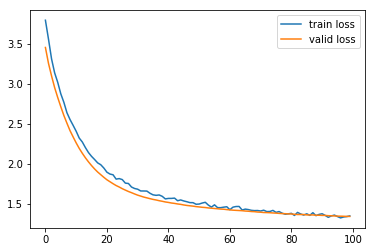

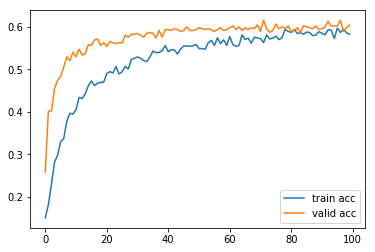

In [8]:
def create_nn(input_size, num_classes):
    inputs = Input(shape=(input_size,))
    x = Dropout(.6)(inputs)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(.6)(x)
    out = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(.1))(x)
    return Model(inputs, out)

model = create_nn(x_train.shape[1], y_train.shape[1])
opt = optimizers.Adam(lr=.0001, beta_1=.95, beta_2=.999, epsilon=1e-8)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

print("\n[info] 开始训练...")
H = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_valid, y_valid), verbose=2)
plt.plot(H.history['loss'], label='train loss')
plt.plot(H.history['val_loss'], label='valid loss')
plt.legend()

plt.figure()
plt.plot(H.history['acc'], label='train acc')
plt.plot(H.history['val_acc'], label='valid acc')
plt.legend()

In [9]:
test_results = model.predict(x_valid)

id2label = {val: key for key, val in valid.class_indices.items()}

print(classification_report(
    y_valid.argmax(axis=1),
    test_results.argmax(axis=1),
    target_names=id2label.values()
))

                 precision    recall  f1-score   support

    black widow       0.56      0.50      0.53        56
captain america       0.49      0.50      0.50        56
 doctor strange       0.62      0.62      0.62        61
           hulk       0.58      0.62      0.60        56
        ironman       0.60      0.62      0.61        56
           loki       0.55      0.56      0.55        54
     spider-man       0.77      0.75      0.76        57
         thanos       0.66      0.65      0.65        57

      micro avg       0.60      0.60      0.60       453
      macro avg       0.60      0.60      0.60       453
   weighted avg       0.61      0.60      0.60       453



In [ ]:
sample_images, sample_labels = valid[0]
sample_images = sample_images[:16]
sample_images = (sample_images + 1) / 2
plt.figure(figsize=(20, 25))
col = 4
row = np.math.ceil(len(sample_images) / col)
for i, image in enumerate(sample_images):
    plt.subplot(row, col, (i+1))
    plt.title(id2label[sample_labels[i].argmax()], fontsize=30)
    plt.text(0, 256, id2label[test_results[i].argmax()], color='red', fontsize=30)
    plt.axis('off')
    plt.imshow(image)

到目前为止我们已经看到我们训练出的模型已经能做到一定程度的识别了. 这时候我们会希望能将训练结果保存起来, 而不是每次需要重新训练才能识别漫威英雄. 

而我们之前是分成了用Inception提取特征, 再用全连通神经网络训练这两步, 用到了两个神经网络模型, 我们需要将其结合成一个:

In [ ]:
bottleneck = feature_extractor.output
out = model(bottleneck)
hero_recognizer = Model(feature_extractor.input, out)

接下来我们测试一下合成的模型是否具有识别功能:

In [ ]:
sample_images, sample_labels = valid[2]
sample_images = sample_images[:16]
pred = hero_recognizer.predict(sample_images)

sample_images = (sample_images + 1) / 2
plt.figure(figsize=(20, 25))
for i, image in enumerate(sample_images):
    plt.subplot(4, 4, (i+1))
    plt.title(id2label[sample_labels[i].argmax()], fontsize=30)
    plt.text(0, 256, id2label[pred[i].argmax()], color='red', fontsize=30)
    plt.axis('off')
    plt.imshow(image)

验证完之后, 我们就可以将训练好的模型保存起来, 方便以后使用了.

In [ ]:
hero_recognizer.save("hero_recognizer.h5")

只要有这个文件, 我们就可以通过加载它来复原我们训练过的模型:

In [ ]:
import cv2
from keras.engine.saving import load_model

hero_recognizer = load_model('hero_recognizer.h5')

用它来对一张图片进行分类:

In [ ]:
test_image = cv2.imread('assets/test0.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

input_image = cv2.resize(test_image, (224, 224))
input_image = normalize_image(input_image)

pred = hero_recognizer.predict(np.array([input_image]))

predicted_hero = id2label[pred.argmax()]
print("The model thinks this image is of [{}].".format(predicted_hero))
display_image(test_image)